# Facial Segmentation
- Segment people into groups by photo similar to the IPhone photos app 

In [151]:
import os, sys
import cv2
import numpy as np
from numpy import asarray
import pandas as pd
import imageai
from tqdm import tqdm
from imageai.Detection.Custom import DetectionModelTrainer
from imageai.Detection.Custom import CustomObjectDetection
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from PIL import Image

**Load Images**

In [ ]:
img_path = r'C:\Users\Matt\OneDrive\GitHub\SmartMirror\SmartMirror\pics\train\images'
images = os.listdir(img_path)

**Train Model**

In [ ]:
path = r"C:\Users\Matt\OneDrive\GitHub\SmartMirror\SmartMirror\pics\models\tiny-yolov3.pt"
# train = DetectionModelTrainer()
# train.setModelTypeAsTinyYOLOv3()
# train.setDataDirectory(data_directory=r"C:\Users\Matt\OneDrive\GitHub\PersonDetection\pics")
# train.setTrainConfig(
#     object_names_array=['face'],
#     batch_size=4,
#     train_from_pretrained_model=path,
#     num_experiments=1000,
    
#     )
# train.trainModel()

train.setTrainConfig(
    object_names_array=['face'],
    batch_size=4,
    train_from_pretrained_model=path,
    num_experiments=1000,
    
    )

In [ ]:
model_path = r"C:\Users\Matt\OneDrive\GitHub\PersonDetection\pics\models\tiny-yolov3_pics_last.pt"
json_path = r"C:\Users\Matt\OneDrive\GitHub\PersonDetection\pics\json\pics_tiny-yolov3_detection_config.json"
detector = CustomObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(model_path)
detector.setJsonPath(json_path)
detector.loadModel()

# Resize Images

In [ ]:
# save_path = r"C:\Users\Matt\OneDrive\GitHub\PersonDetection\resized_pics"
# for i in tqdm(images): 
#     image = Image.open(os.path.join(img_path,i,))
#     resize = image.resize((400,400))
#     resize.save(os.path.join(save_path, i))

In [211]:
resize.save('test3.jpg')

**Detect People in Images**

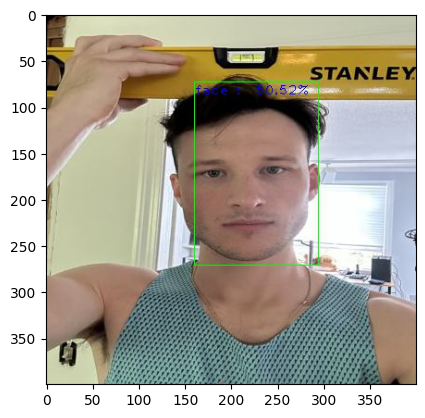

In [212]:
res = detector.detectObjectsFromImage(
    input_image = 'test3.jpg',
    output_image_path='test4.jpg',
    minimum_percentage_probability=45
)
plt.imshow(Image.open('test4.jpg'))

# Trim image to box shape

In [ ]:
coords = res[0]['box_points']

In [ ]:
img = Image.open('test2.jpg')

**Grab Faces**

In [ ]:
img = cv2.imread('test2.jpg')
cropped = img[coords[1]:coords[3],coords[0]:coords[2]] # img[y:range, x:range]

In [ ]:
cv2.imshow('cropped',cropped)
cv2.waitKey(0)

# Make predictions on entire feature set 

In [215]:
def predict(img): 
    
    res = detector.detectObjectsFromImage(
    input_image = os.path.join(save_path,img),
    output_image_path='test2.jpg',
    minimum_percentage_probability=45
    )
    return res

In [216]:
preds = list()
photo = list()
for image in tqdm(images): 
    preds.append(predict(image))

  0%|                                                                                                                   | 0/172 [00:00<?, ?it/s]C:\Users\Matt\AppData\Local\Temp\ipykernel_19468\747360874.py:3: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\Users\\Matt\\OneDrive\\GitHub\\SmartMirror\\SmartMirror\\pics\\train\\images\\IMG_1876.JPEG'>
  for image in tqdm(images):
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:02<00:00, 64.03it/s]


**Save sliced image**

In [217]:
master_imgs = list()
master_preds = list()
for img in range(len(images)): 
    for pred in preds[img]:
        master_imgs.append(images[img])
        master_preds.append(pred)

In [218]:
df = pd.DataFrame([master_imgs,master_preds],index=['Image','Prediction']).T

In [219]:
# img[coords[1]:coords[3],coords[0]:coords[2]] # img[y:range, x:range]

In [220]:
df['coord 0'] = df['Prediction'].str['box_points'].str[0]
df['coord 1'] = df['Prediction'].str['box_points'].str[1]
df['coord 2'] = df['Prediction'].str['box_points'].str[2]
df['coord 3'] = df['Prediction'].str['box_points'].str[3]

In [227]:
def crop(image, x1,x2,y1,y2): 
    # load img
    i = cv2.imread(os.path.join(img_path, image), cv2.IMREAD_GRAYSCALE)
    # crop img
    return i[y1:y2,x1:x2]

In [228]:
df['crop'] = None
for i in tqdm(range(len(df))): 
    cropped = crop(os.path.join(img_path,df['Image'][i]),
                      df['coord 1'][i],
                      df['coord 3'][i],
                      df['coord 0'][i],
                      df['coord 2'][i],
        )
    df['crop'][i] = cropped

  0%|                                                                                                                     | 0/1 [00:00<?, ?it/s]C:\Users\Matt\AppData\Local\Temp\ipykernel_19468\2400593313.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['crop'][i] = cropped
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'



In [226]:
df['crop'][2].shape

(30, 29)

# Analysis

In [166]:
img = cv2.imread('test2.jpg', cv2.IMREAD_GRAYSCALE)

In [171]:
# Importing Image class from PIL module
from PIL import Image
 
# Opens a image in RGB mode
im = Image.open(r"test2.jpg")
 
sunset_resized = im.resize((400, 400)) 

C:\Users\Matt\AppData\Local\Temp\ipykernel_19468\549728197.py:5: ResourceWarning: unclosed file <_io.BufferedReader name='test2.jpg'>
  im = Image.open(r"test2.jpg")


In [173]:
cv2.imread(sunset_resized)

TypeError: Can't convert object to 'str' for 'filename'